In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [3]:
dataset = pd.read_csv("../../datasets/toxic_comments_1.csv",nrows=4000)

In [4]:
dataset = dataset[["comment_text","toxic"]]

In [5]:
#cleaning the text
dataset.columns = ["comment","toxic"]
dataset["comment"] = dataset["comment"].str.replace("\n"," ")

In [6]:
bag_of_words = []
import re
for i in range(0,4000):
    words = re.sub('[^a-zA-Z]',' ',dataset["comment"][i])
    words = words.lower().split()
    words = [word for word in words if not word in set(stopwords.words("english"))]
    sentence = ' '.join(words)
    bag_of_words.append(sentence)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
tokenizer = Tokenizer(num_words=30000)

In [9]:
tokenizer.fit_on_texts(np.array(bag_of_words))

In [10]:
X = tokenizer.texts_to_sequences(np.array(bag_of_words))
X = sequence.pad_sequences(X,maxlen=50)

In [11]:
y = dataset["toxic"].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
model = Sequential()
model.add(Embedding(30000,100))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

In [13]:
#functions to calculate recall,precision and f1_score
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])

In [14]:
history = model.fit(X_train,y_train,batch_size=45,epochs=5,verbose=2,validation_data=(X_test,y_test))

Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 - 32s - loss: 0.3740 - accuracy: 0.8897 - f1_m: 0.0017 - precision_m: 9.5785e-04 - recall_m: 0.0093 - val_loss: 0.3100 - val_accuracy: 0.9038 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
3200/3200 - 21s - loss: 0.2251 - accuracy: 0.9153 - f1_m: 0.2519 - precision_m: 0.4016 - recall_m: 0.2030 - val_loss: 0.2086 - val_accuracy: 0.9375 - val_f1_m: 0.5074 - val_precision_m: 0.8333 - val_recall_m: 0.3952
Epoch 3/5
3200/3200 - 21s - loss: 0.0676 - accuracy: 0.9756 - f1_m: 0.8641 - precision_m: 0.9415 - recall_m: 0.8299 - val_loss: 0.2322 - val_accuracy: 0.9400 - val_f1_m: 0.5503 - val_precision_m: 0.7778 - val_recall_m: 0.4513
Epoch 4/5
3200/3200 - 23s - loss: 0.0218 - accuracy: 0.9937 - f1_m: 0.9474 - precision_m: 0.9610 - recall_m: 0.9395 - val_loss: 0.2337 - val_accuracy: 0.9375 - val_f1_m: 0.5808 - val_precision_m: 0.7176 - val_recall_m: 0.5552
Epoch 5/5
3200/3200 - 21s - loss:

In [23]:
from sklearn.metrics import roc_curve


In [24]:
y_pred = model.predict(X_test)

In [17]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

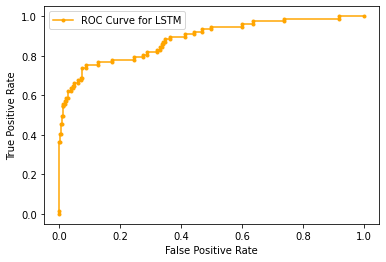

In [18]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve for LSTM',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [19]:
y_pred[y_pred > 0.5]

array([0.5086946 , 0.99439704, 0.97754925, 0.9721286 , 0.54150885,
       0.9958295 , 0.7693325 , 0.97525793, 0.8365319 , 0.976895  ,
       0.99640805, 0.99677795, 0.99867165, 0.8658407 , 0.9680986 ,
       0.9887045 , 0.97796977, 0.99740237, 0.7170916 , 0.95729584,
       0.7571891 , 0.9985464 , 0.9958431 , 0.7442507 , 0.75894195,
       0.5301066 , 0.5211489 , 0.7789859 , 0.9976042 , 0.7835179 ,
       0.9990306 , 0.9976428 , 0.99931407, 0.79336226, 0.9845941 ,
       0.9968683 , 0.80614424, 0.96808285, 0.99043053, 0.9977724 ,
       0.9790724 , 0.9868804 , 0.9945791 , 0.87563044], dtype=float32)

In [20]:
#al
results = []
for result in y_pred:
    if result > 0.5:
        results.append(1)
    else:
        results.append(0)
results = np.array(results)

In [25]:
from sklearn.metrics import roc_auc_score,confusion_matrix
def get_roc_area_and_tp_and_fp_rates():
    cm = confusion_matrix(y_test,results)
    tn, fp, fn, tp = cm.ravel()
    print("True positive rate = ",tp/(tp + fn))
    print("False positive rate = ",fp/(tn + fp))
    area = roc_auc_score(y_test,results)
    print("ROC area == ",area)
    
get_roc_area_and_tp_and_fp_rates()
    

True positive rate =  0.4935064935064935
False positive rate =  0.008298755186721992
ROC area ==  0.7426038691598857
